In [ ]:
!pip install --upgrade tensorflow==1.15

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('X train:', x_train.shape)
print('y train:', y_train.shape)
print('X test:', x_test.shape)
print('y test:', y_test.shape)

X train: (60000, 28, 28)
y train: (60000,)
X test: (10000, 28, 28)
y test: (10000,)


**Pada code diatas saya langsung menload data fashion mnist dari tensorflow keras untuk langsung displit menjadi training set dan juga test set lengkap dengan x sebagai featurenya dan y sebagai labelnya atau indikasi kelasnya. Didapat bahwa shape atau bentuk data berukuran 2 dimensi dengan besar pixel sebesar 28 px x 28 px. Dengan data train sebesar 60.000 data dan data test sebesar 10.000 data**







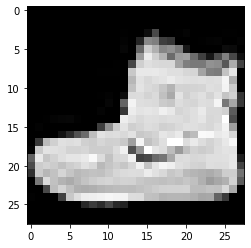

In [ ]:
plt.imshow(x_train[0], cmap='gray')
plt.show()

**Diatas adalah contoh gambar sample yang diambil dari data 
paling pertama dari x train dimana dapat dilihat bahwa ukuran gambar 28 pixel x 28 pixel**

In [ ]:
print(y_train)

[9 0 0 ... 3 0 5]


**Ini adalah data label train yang dimunculkan yang berfungsi sebagai label klasifikasi dari kelas yang ada pada dataset tersebut dimana sebanyak 10 kelas (0-9).**

In [ ]:
# Preprocess Label
y_train = y_train.reshape([-1, 1])
y_test = y_test.reshape([-1, 1])

**Diatas label dipreprocess agar dimensinya dapat cocok dengan model yang ingin diisi atau ditrain**

In [ ]:
print(y_train)

[[9]
 [0]
 [0]
 ...
 [3]
 [0]
 [5]]


**Diatas adalah hasil dari label train yang sudah direshape**

In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# Preprocess Image
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

In [ ]:
# MinMaxScaler
# 0 - 255 | 127.5
# 0 - 1   | 0.5
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
input_placeholder = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
label_placeholder = tf.placeholder(tf.float32, shape=[None, 10])

**Setelah semua data telah disiapkan atau di preprocess lalu placeholder atau tempat menampung datanya dibuat dimana disini saya membuat 2 placeholder yaitu untuk input atau x dan juga untuk labelnya atau y. Dimana dimensi input sebesar 28x28x1 yang melambangkan ukuran dari inputnya yaitu gamabar dengan 28 pixel x 28 pixel dan 1 untuk mewakili jumlah warna dimana dapat dilihat sebelumnya bahwa gambar yang ada pada dataset hanya memiliki 1 kombinasi warna yaitu greyscale atau hitam dan putih. Sedangkan untuk labelnya memiliki ukuran sebesar 10 yang mewakili jumlah class yang ada atau label yang ada yaitu 10 (0-9)**

In [ ]:
def dense(x, neuron_size, activation=None):
  in_shape = x.shape[-1]

  weight = tf.Variable(
      tf.random.normal([in_shape, neuron_size])
  )
  bias = tf.Variable(
      tf.random.normal([neuron_size])
  )
  out = tf.matmul(x, weight) + bias

  if not activation: # Linear Activation
    return out

  return activation(out)

In [ ]:
def flatten(x):
  res = 1
  for s in x.shape[1:]:
    res *= s

  return tf.reshape(x, [-1, res])

In [ ]:
def conv2d(x, out_channels, kernel_size, strides=1, padding="SAME", activation=tf.nn.relu): 
  in_channels = x.shape[-1]

  kernel = tf.Variable(
      tf.random.normal([kernel_size, kernel_size, in_channels, out_channels])
  )
  bias = tf.Variable(
      tf.random.normal([out_channels])
  )

  out = tf.nn.conv2d(x, kernel, strides=strides, padding=padding) + bias

  if not activation:
    return out

  return activation(out)

**Diatas saya mendefinisikan sebuah function atau model Convolutional 2d dengan padding "SAME" karena input dan ouputnya nantinya akan memiliki dimensi yang sama. Setelah itu saya membuat function untuk kernel, bias, dan out dari model itu nantinya.**

In [ ]:
# Feed Forward
out_conv1 = conv2d(input_placeholder, 8, 3, activation=tf.nn.relu)
pooled1 = tf.nn.max_pool2d(out_conv1, 2, strides=2, padding="SAME")

out_conv2 = conv2d(pooled1, 16, 3, activation=tf.nn.relu)
pooled2 = tf.nn.max_pool2d(out_conv2, 2, strides=2, padding="SAME")

flattened = flatten(pooled2)

output_tensor = dense(flattened, 10)

# logits : [0, 1, 0 , 0.5] (logits = output raw)
# label : [1, 0, 0, 0]
loss_tensor = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
    logits = output_tensor,
    labels = label_placeholder
  )
)

train = tf.train.AdamOptimizer(0.01).minimize(loss_tensor)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



**Lalu diatas dapat dilihat bahwa untuk training optimizernya saya menggunakan AdamOptimizer**

In [ ]:
# Batch training
def get_batch(iteration, x, y, batch_size):
  start_idx = iteration * batch_size
  data_len = x.shape[0]

  x_batch = x[start_idx: min(start_idx + batch_size, data_len)]
  y_batch = y[start_idx: min(start_idx + batch_size, data_len)]
  return x_batch, y_batch

In [ ]:
def accuracy_score(y_pred, y_true):
  matches = tf.equal(
      tf.argmax(y_pred, 1), 
      tf.argmax(y_true, 1) 
  )
  return tf.reduce_mean(tf.cast(matches, tf.float32))

**Diatas saya membuat function untuk mencari angka akurasi yang nantinya akan berguna untuk terus mengeluarkan dan keep track pada angka akurasi untuk setiap epochnya nanti jika model sudah dijalankan**

In [ ]:
num_epochs = 10
batch_size = 520
iter_len = x_train.shape[0] // batch_size # / bagi  // bagi abis itu floor
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for epoch in range(num_epochs):
    print('')
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('')
    for iteration in range(iter_len):
      x_batch, y_batch = get_batch(iteration, x_train, y_train, batch_size)
      
      train_dict = {
          input_placeholder : x_batch,
          label_placeholder : y_batch
      }

      sess.run(train, feed_dict = train_dict)

      loss = sess.run(loss_tensor, feed_dict = train_dict)
      acc = sess.run(accuracy_score(output_tensor, label_placeholder), feed_dict = train_dict)

      if iteration % 20 == 0:
        print(f'{iteration}/{iter_len} - loss : {loss:.4f} - acc : {acc:4f}')

    test_dict = {
        input_placeholder: x_test,
        label_placeholder: y_test
    }
    val_loss = sess.run(loss_tensor, feed_dict = test_dict)
    val_acc = sess.run(
        accuracy_score(output_tensor, label_placeholder),
        feed_dict = test_dict
    )
    print('====')
    print('Validation Loss: ', val_loss)
    print('Validation Acc: ', val_acc)


Epoch 1/10

0/115 - loss : 328.6817 - acc : 0.159615
20/115 - loss : 45.1006 - acc : 0.294231
40/115 - loss : 16.3243 - acc : 0.534615
60/115 - loss : 11.8285 - acc : 0.584615
80/115 - loss : 9.3686 - acc : 0.626923
100/115 - loss : 7.6628 - acc : 0.700000
====
Validation Loss:  7.1406264
Validation Acc:  0.671

Epoch 2/10

0/115 - loss : 6.6681 - acc : 0.711538
20/115 - loss : 6.0935 - acc : 0.694231
40/115 - loss : 4.9741 - acc : 0.717308
60/115 - loss : 4.1627 - acc : 0.732692
80/115 - loss : 4.0801 - acc : 0.728846
100/115 - loss : 4.1309 - acc : 0.736538
====
Validation Loss:  3.8814378
Validation Acc:  0.7307

Epoch 3/10

0/115 - loss : 3.3343 - acc : 0.755769
20/115 - loss : 3.3690 - acc : 0.736538
40/115 - loss : 2.8014 - acc : 0.778846
60/115 - loss : 2.4945 - acc : 0.746154
80/115 - loss : 2.5474 - acc : 0.755769
100/115 - loss : 2.7853 - acc : 0.761538
====
Validation Loss:  2.6704168
Validation Acc:  0.7481

Epoch 4/10

0/115 - loss : 2.2457 - acc : 0.780769
20/115 - loss 

**Diatas saya menjalankan training pada model sebanyak 10 epoch dengan batchsize sebesar 520 dan juga dengan iterasi sebesar 115 untuk setiap epochnya. Lalu untuk setiap selesai 1 epoch maka program atau model akan mengeluarkan Validation loss atau validasi errornya beserta dengan validasi accuracy atau akurasi akhirnya. Sedangkan untuk setiap 20 epoch model akan mengeluarkan loss atau error dan juga akurasi yang didapat saat itu.**